### Installing all necessary libraries and importing them

In [7]:
import pandas
import numpy as np 
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt


from plotly.offline import *

init_notebook_mode(connected = True)
%matplotlib inline

import folium
from scipy.stats import chi2_contingency
from folium.plugins import MarkerCluster


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier



from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score


from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

from imblearn.under_sampling import RandomUnderSampler


## Data Scrubbing and Data Understanding

In [8]:
df = pd.read_csv("datasets/Train.csv")
df.head(3)

,INDEX_,ACCNUM,YEAR,DATE,TIME,STREET1,STREET2,OFFSET,ROAD_CLASS,DISTRICT,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,DIVISION,ObjectId
0,3387730,892658.0,2006,2006/03/11 05:00:00+00,852,BLOOR ST W,DUNDAS ST W,NaN,Major Arterial,Toronto and East York,...,Yes,NaN,NaN,NaN,88,High Park North,88,High Park North (88),D11,1
1,3387731,892658.0,2006,2006/03/11 05:00:00+00,852,BLOOR ST W,DUNDAS ST W,NaN,Major Arterial,Toronto and East York,...,Yes,NaN,NaN,NaN,88,High Park North,88,High Park North (88),D11,2
2,3388101,892810.0,2006,2006/03/11 05:00:00+00,915,MORNINGSIDE AVE,SHEPPARD AVE E,NaN,Major Arterial,Scarborough,...,Yes,Yes,NaN,NaN,146,Malvern East,132,Malvern (132),D42,3


**Checking Redundant/duplicate rows in the dataframe:**

In [9]:
unique_id = df['INDEX_'].nunique()

total_rows = df.shape[0]

print(f"Total Duplicate Rows: {total_rows-unique_id}")

#Removing the duplicate rows.
df = df.sort_values("INDEX_", ascending=False).drop_duplicates(subset='INDEX_', keep="first")

print(f"After Dropping duplicates, Number of row Before : {total_rows}, After  : {df.shape[0]}")

Total Duplicate Rows: 0
After Dropping duplicates, Number of row Before : 15000, After  : 15000


**Removing Noise Features and Features that may cause Data Leak**

- `FATAL_NO` is assigned only to accidents that resulted in fatalities. It would be inappropriate because it would introduce data leakage.
- `INDEX_`, `ACCNUM`, `ObjectId` are unique identifiers.

In [10]:
df.drop(["INDEX_", "ObjectId", "ACCNUM", "FATAL_NO"], axis= 1 , inplace= True)


**Getting all Categorical and Continious dtypes**

In [11]:
# Step 1: Get all the object
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {cat_columns}")

# Step 2: Get all numeric data types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
print(f"Numerical columns: {numerical_cols}")


print(f"Total Columns in datase: {df.shape[1]}")
print(f"Identified data type: {len(cat_columns) + len(numerical_cols)}")

assert df.shape[1] == len(cat_columns) + len(numerical_cols) , "Some columns not indentified."

Categorical columns: ['DATE', 'STREET1', 'STREET2', 'OFFSET', 'ROAD_CLASS', 'DISTRICT', 'LOCCOORD', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 'DIVISION']
Numerical columns: ['YEAR', 'TIME', 'WARDNUM', 'LATITUDE', 'LONGITUDE']
Total Columns in datase: 51
Identified data type: 51


**Some numberic columns might also be categorical. So, lets check sanity of numerical columns**

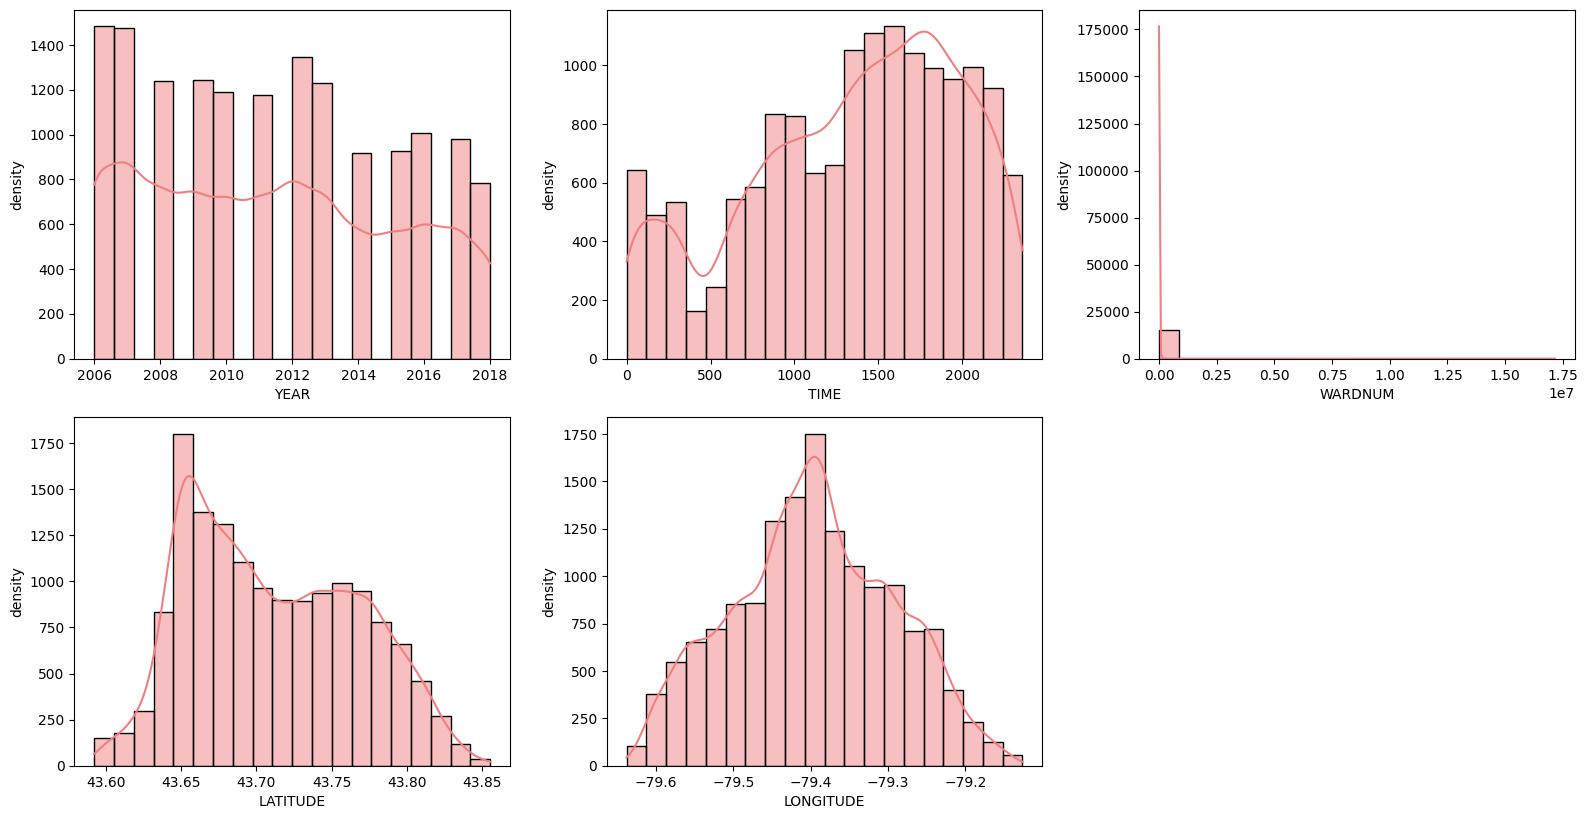

In [12]:
 
numerical_df = df[numerical_cols]

plt.figure(figsize=(16, 16))
for feature in numerical_df.columns.to_list():
    plt.subplot(4, 3, numerical_df.columns.to_list().index(feature) + 1)
    sns.histplot(data=numerical_df[feature], bins=20, kde=True, color="lightcoral")
    plt.ylabel("density")
plt.tight_layout()
plt.show()

## Data Cleaning

### Handelling the missing values

<Axes: >

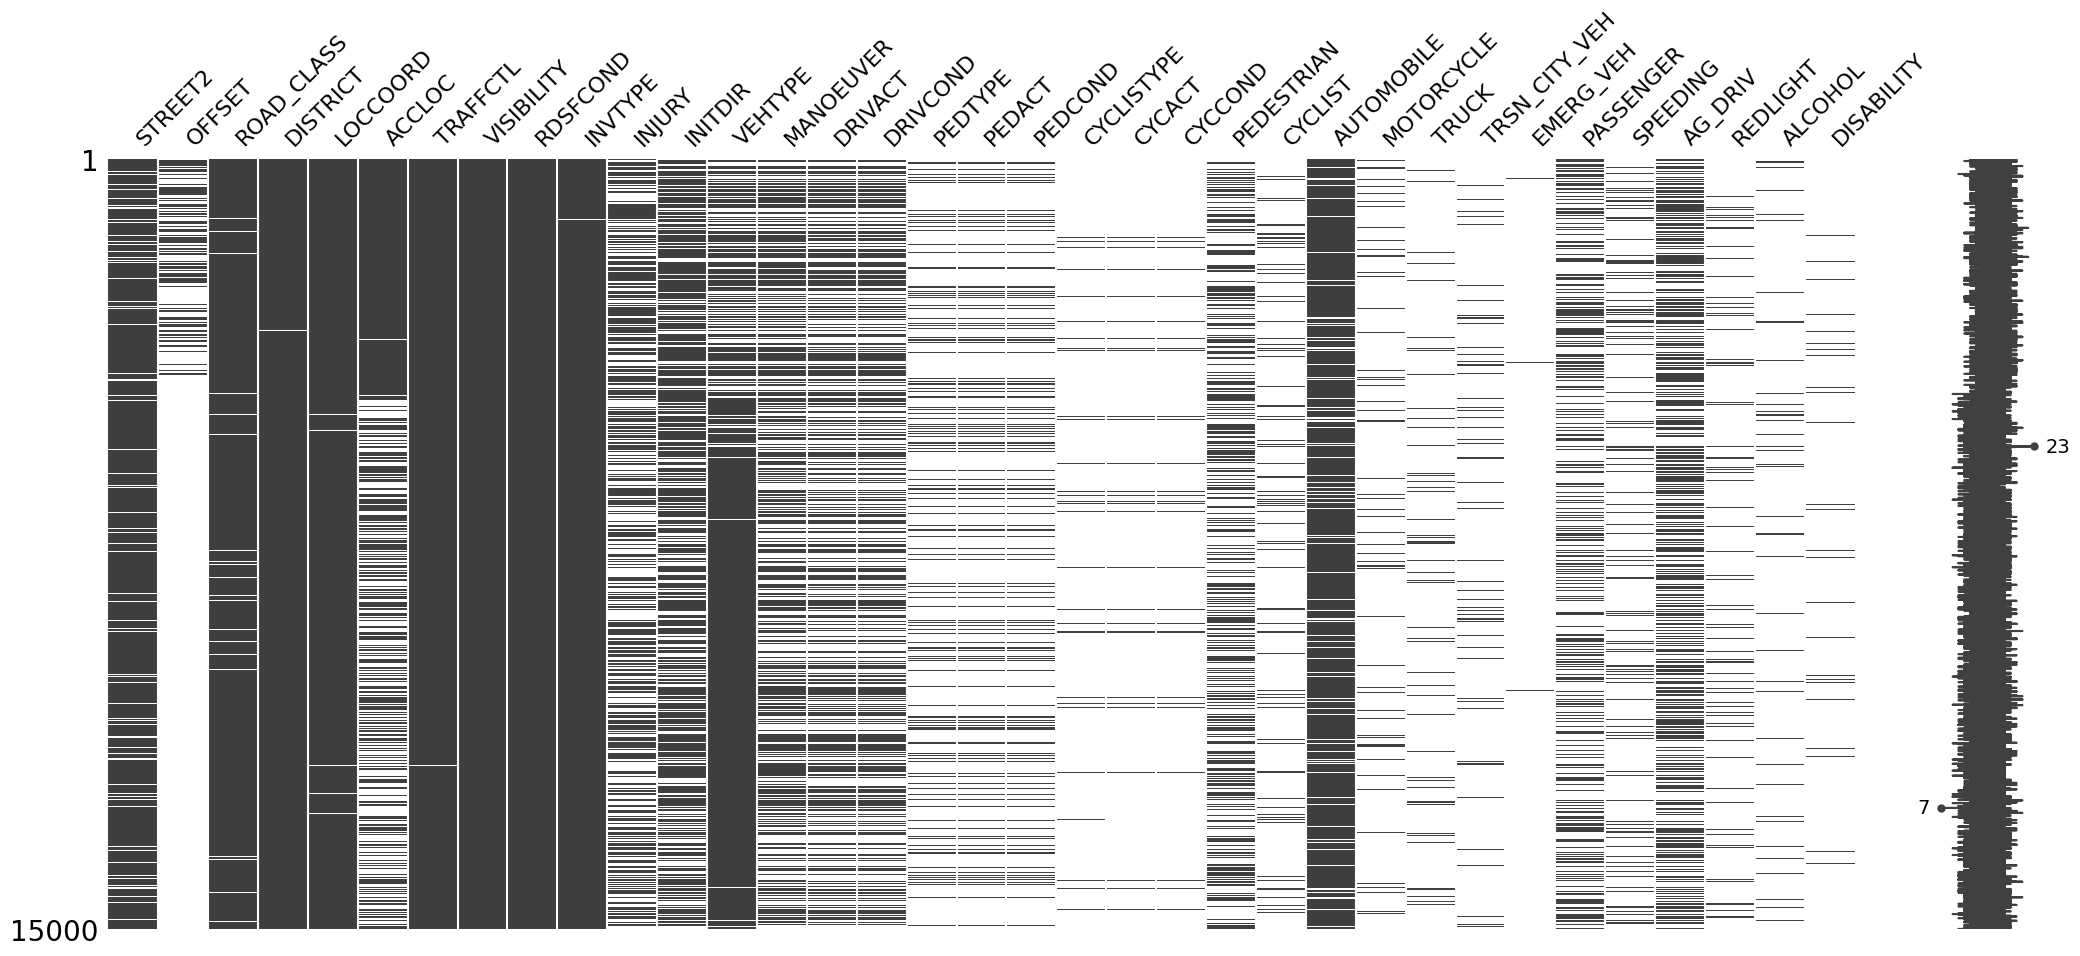

In [13]:
# get all columns with missing values.

col_mis_val = df.columns[df.isnull().sum() > 0]
col_mis_val = col_mis_val.to_list()

# visualize missing values with missingno.

msno.matrix(df[col_mis_val])

**Data Completeness PER Feature**

<Axes: >

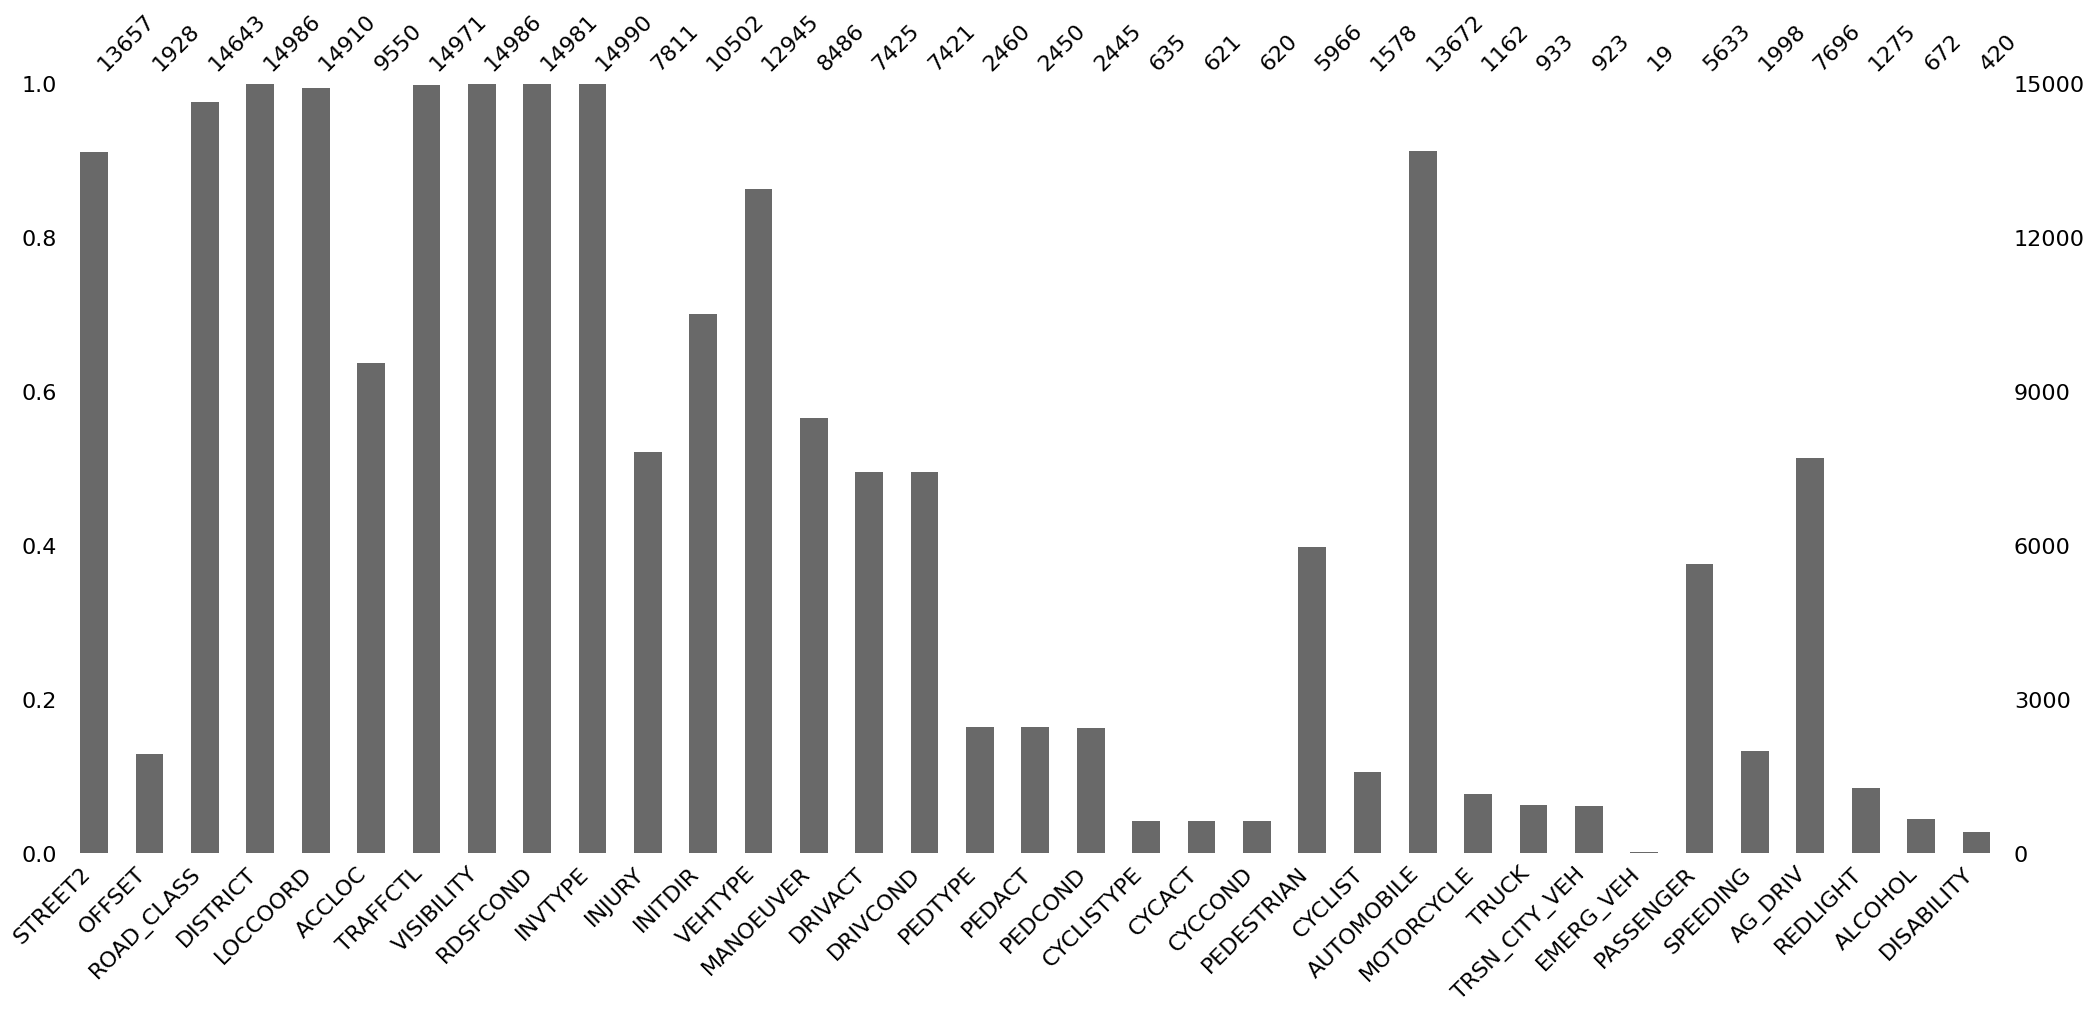

In [14]:
msno.bar(df[col_mis_val])

**Get all columns whose missing values are greater than 50% and drop them**

In [15]:

to_be_dropeed = df[col_mis_val].columns[df[col_mis_val].isna().mean() * 100 > 50]
print(f"We are dropping these columns: {to_be_dropeed}")
df.drop(to_be_dropeed, axis=1, inplace= True)


We are dropping these columns: Index(['OFFSET', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND',
       'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST',
       'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER',
       'SPEEDING', 'REDLIGHT', 'ALCOHOL', 'DISABILITY'],
      dtype='object')


In [16]:
df.isnull().sum()

YEAR                    0
DATE                    0
TIME                    0
STREET1                 0
STREET2              1343
ROAD_CLASS            357
DISTRICT               14
WARDNUM                 0
LATITUDE                0
LONGITUDE               0
LOCCOORD               90
ACCLOC               5450
TRAFFCTL               29
VISIBILITY             14
LIGHT                   0
RDSFCOND               19
ACCLASS                 0
IMPACTYPE               0
INVTYPE                10
INVAGE                  0
INJURY               7189
INITDIR              4498
VEHTYPE              2055
MANOEUVER            6514
AUTOMOBILE           1328
AG_DRIV              7304
HOOD_158                0
NEIGHBOURHOOD_158       0
HOOD_140                0
NEIGHBOURHOOD_140       0
DIVISION                0
dtype: int64

In [17]:
df.ACCLASS.value_counts()

ACCLASS
Non-Fatal Injury    12978
Fatal                2022
Name: count, dtype: int64

**As dataset is unbalanced, drop the rows if in Non-Fatal Injury has more than 2 missing values**

In [ ]:

# rows_to_drop = df.loc[df["ACCLASS"] == "Non-Fatal Injury"].isnull().sum(axis=1) > 2

# indexes_to_drop = list(rows_to_drop[rows_to_drop].index)

# df = df.drop(indexes_to_drop, axis=0)

**Are all missing values from categorical columns?**

In [18]:
# Again lets have a look at columns with missing values
col_mis_val = df.columns[df.isnull().sum() > 0].to_list()

# check if all missing values are now from categorical datatypes.
set(col_mis_val).issubset(set(cat_columns))

True

### Checking distribution of each calss before handlling the missing values.

In [19]:
class CustomPIE:
    """
    Plot a Single and grid pie chart from the given dataframe.
    """
    def __init__(self, df : pd.DataFrame , fontsize : int = 15 ) -> None:

        self.df = df
        self.font_size = fontsize
        assert isinstance(df, pandas.core.frame.DataFrame), "Only pandas dataframe is supported."

    
    def pie_categorical(self, column_name : str):
        """Plot pie chart for given categorical data.

        Args:
            columnName (str): name of the specefic column.
        """
        values = self.df[column_name].value_counts()

        plt.figure(figsize=[10, 8])
        patches, texts, autotexts = plt.pie(values, labels=values.index,
                                            autopct='%1.2f%%', shadow=True,
                                            pctdistance=.5, explode=[0.07]*len(values))
        
        plt.title(f"Pie chart of : {column_name}", fontsize=self.font_size)
        plt.legend(patches, values.index, loc="best")
        plt.axis('equal')
        plt.tight_layout()

        plt.show()



    def grid_pie(self,column_names : list):
        """Plot grid pie chart dynamically from given list of column names.

        Args:
            columnNames (list): list of column names.
        """
        assert isinstance(column_names , list), "Only column name in list is supported."
        
        n = len(column_names)
        # identify number of columns
        ncols = int(np.ceil(np.sqrt(n)))

        # identify number of rows
        nrows = int(np.ceil(n / ncols))
        
        # define grid to plot the pie.
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*10, nrows*8))
        
        for ax, columnName in zip(axs.flatten(), column_names):

            # get value count for each of the column.
            values = self.df[columnName].value_counts()

            patches, texts, autotexts = ax.pie(values, labels=values.index, 
                                               autopct='%1.2f%%', 
                                               shadow=True, 
                                               pctdistance=.5, explode=[0.07]*len(values))
            ax.set_title(f"Pie chart of : {columnName}", fontsize=self.font_size)
    
            ax.legend(patches, values.index, loc="best")
    
            ax.axis('equal')
        
        plt.tight_layout()
        plt.show()

# define the custom plotter
cust_plot = CustomPIE(df=df, fontsize=10)

In [20]:
print("Number of Categories in: ")
for ColName in df[col_mis_val]:
    print("{} = {}".format(ColName, len(df[ColName].unique())))

Number of Categories in: 
STREET2 = 2345
ROAD_CLASS = 10
DISTRICT = 5
LOCCOORD = 8
ACCLOC = 10
TRAFFCTL = 11
VISIBILITY = 9
RDSFCOND = 10
INVTYPE = 19
INJURY = 5
INITDIR = 6
VEHTYPE = 28
MANOEUVER = 17
AUTOMOBILE = 2
AG_DRIV = 2


**For Binary Features**

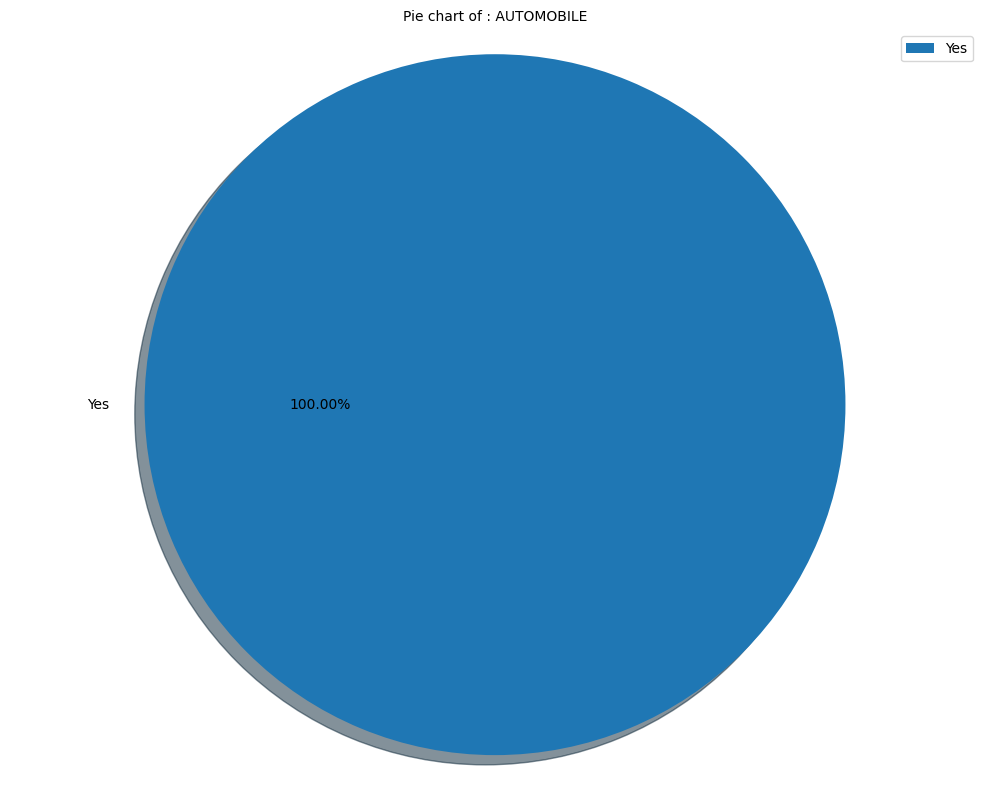

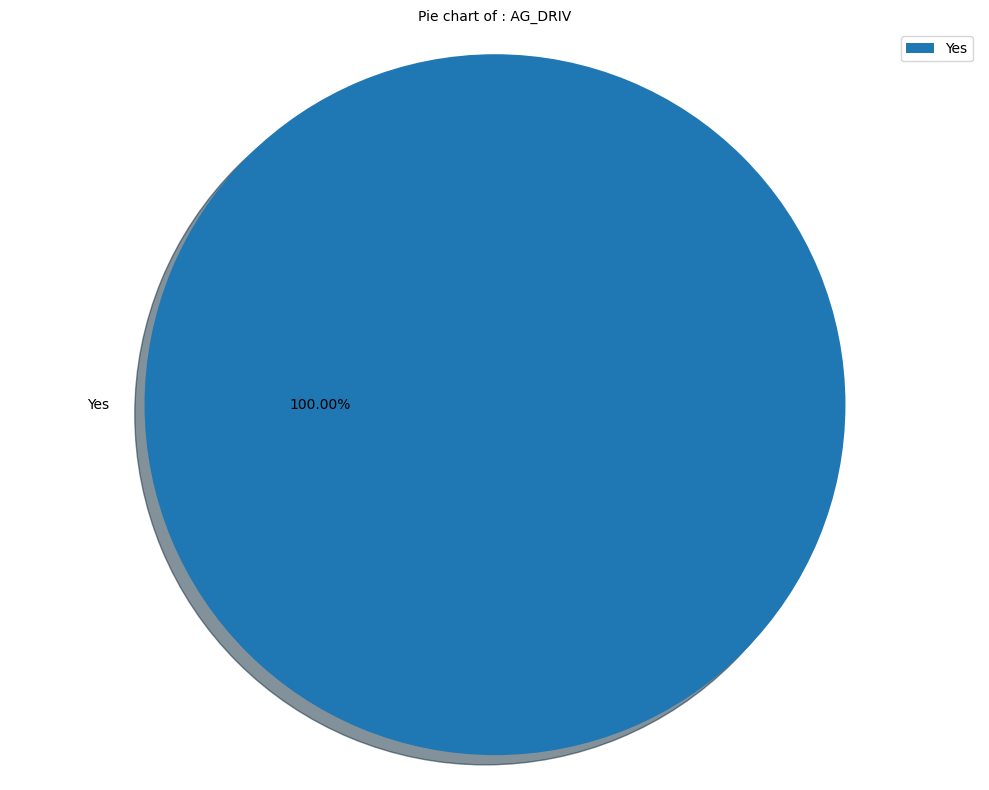

In [21]:
cust_plot.pie_categorical(column_name="AUTOMOBILE")

cust_plot.pie_categorical(column_name="AG_DRIV")

**Findings**: 
- Drop `AUTOMOBILE` and `AG_DRIV` as they are unbalanced. 
- For `STREET2`, since it has a vast number of categories, imputing a missing value with the most frequent category (mode) might not be very informative. A placeholder such as "Unknown" could be more appropriate, maintaining the integrity of the data while acknowledging the missing information.
- For columns like ROAD_CLASS, DISTRICT, LOCCOORD, and ACCLOC that have a relatively small number of categories, replacing missing values with the mode (the most common category) can be a simple and effective strategy.

In [22]:
df.isnull().sum()

YEAR                    0
DATE                    0
TIME                    0
STREET1                 0
STREET2              1343
ROAD_CLASS            357
DISTRICT               14
WARDNUM                 0
LATITUDE                0
LONGITUDE               0
LOCCOORD               90
ACCLOC               5450
TRAFFCTL               29
VISIBILITY             14
LIGHT                   0
RDSFCOND               19
ACCLASS                 0
IMPACTYPE               0
INVTYPE                10
INVAGE                  0
INJURY               7189
INITDIR              4498
VEHTYPE              2055
MANOEUVER            6514
AUTOMOBILE           1328
AG_DRIV              7304
HOOD_158                0
NEIGHBOURHOOD_158       0
HOOD_140                0
NEIGHBOURHOOD_140       0
DIVISION                0
dtype: int64

In [ ]:
# dropping the AUTOMOBILE and AG_DRIV 
df.drop(["AUTOMOBILE", "AG_DRIV" ], axis=1 , inplace= True )

# remove these two columns from 
# our missing values list 
col_mis_val.remove("AUTOMOBILE")
col_mis_val.remove("AG_DRIV")


# Remove STREET2 as we dont want to perform mode imputation on it. 
col_mis_val.remove("STREET2")


**Last check on all of the remaining columns to check dataset balance.**

In [ ]:
cust_plot.grid_pie(col_mis_val)

In [ ]:
# Handelling missing values for STREET2
df['STREET2'] = df['STREET2'].fillna('Unknown')

# Mode imputation for columns with moderate to few categories
for col in col_mis_val:
    mode_value = df[col].mode()[0]
    print(f"Mode of column : {col} is : {mode_value} ")
    df[col] = df[col].fillna(mode_value)

In [ ]:
# check for missing values 
df.isnull().sum()

## EDA

In [ ]:
# Convert TIME into Hour and drop Hour 

df['HOUR'] = df['TIME'].astype(str).str.zfill(4).str[:2].astype(int)

df.drop("TIME", axis= 1 , inplace= True)

# Ensure 'DATE' is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month

**Accidents By Month**

In [ ]:
# define month name 
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Group by YEAR + MONTH + COunt 
monthly_accidents = df.groupby(['YEAR', 'MONTH']).size().reset_index(name='counts')
# PIVOT
pivot_df = monthly_accidents.pivot(index='MONTH', columns='YEAR', values='counts').fillna(0)


fig = px.line(pivot_df, x=pivot_df.index, y=pivot_df.columns,
              labels={'value':'Number of Accidents', 'index':'Month'},
              title='Monthly accidents for each year', 
              template='plotly_dark')

fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=month_names)
fig.update_layout(xaxis_title='Month',
                yaxis_title='Number of Accidents',
                legend_title="Different Years", height = 800)

fig.show()

**Accident distribution each year.**

In [ ]:
# Group by year and ACLASSS
acp = df.groupby('YEAR')['ACCLASS'].value_counts().unstack()

# define bar plot
fig = px.bar(acp.reset_index(), x='YEAR', y=acp.columns,
             title="Proportion of ACCLASS Categories by Year", 
             template='plotly_dark'
             )

fig.update_layout(barmode='group', xaxis_title='Year', yaxis_title='Proportion',
                  legend_title="ACCLASS Categories", height = 800)


fig.show()

**Accident distribution each month.**

In [ ]:
# Group by month and ACCLASS
# then count occurences
mcd = df.groupby(['MONTH', 'ACCLASS']).size().reset_index(name='counts')

# pivot for easy plot
pivot_df = mcd.pivot(index='MONTH', columns='ACCLASS', values='counts').fillna(0)

# define line plot
fig = px.line(pivot_df, x=pivot_df.index, y=pivot_df.columns, title='ACCLASS Distribution by Month',
              labels={'value':'Number of Cases', 'variable':'ACCLASS', 'MONTH':'Month'},
              template='plotly_dark')

# add month name for x tick 
fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=month_names)
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Cases', 
                  legend_title="ACCLASS Categories",
                  height = 800)

fig.show()

**Accident distribution each hour of the day.**

In [ ]:

# Group by 'HOUR' and 'ACCLASS' 
# count occurances

hourly_distribution = df.groupby(['HOUR', 'ACCLASS']).size().reset_index(name='counts')

# define line plot
fig = px.line(hourly_distribution, x='HOUR', y='counts', color='ACCLASS',
              labels={'counts':'Number of Accidents', 'HOUR':'Hour of the Day'},
              title='Hourly Distribution of Fatal and Non-Fatal Accidents', 
              template='plotly_dark')


fig.update_layout(xaxis=dict(tickmode='linear', dtick=1), height = 800)

fig.show()


**Accident Distribution Across Different Road Classifications**

In [ ]:
fig = px.histogram(df, x='ROAD_CLASS', color='ACCLASS',
                   title='Distribution of Accidents Across Different Road Classifications by Accident Severity',
                   labels={'ROAD_CLASS': 'Road Classification', 'ACCLASS': 'Accident Severity'},
                   barmode='group', 
                   category_orders={"ACCLASS": ["Fatal", "Non-Fatal Injury"]},  
                   text_auto=True, 
                   template='plotly_dark')

fig.update_layout(xaxis_title='Road Classification',
                  yaxis_title='Number of Accidents',
                  legend_title_text='Accident Severity',
                  bargap=0.2,  
                  height=800
                  )

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

**Get top 10 streets where most accidents occur and get the time where most accidents occur**

In [ ]:
# Filter the DataFrame for fatal accidents
fatal_accidents = df[df['ACCLASS'] == 'Fatal']

# Find the top 10 streets for fatal accidents
top_streets_fatal = fatal_accidents['STREET1'].value_counts().head(10).index

# dict to save street + most common hour
top_streets_time = {}

for street in top_streets_fatal:
    # Filter for accidents on this street
    street_data = fatal_accidents[fatal_accidents['STREET1'] == street]
    
    # Find the most common hour for accidents on this street
    common_hour = street_data['HOUR'].value_counts().idxmax()
    
    # Store the result
    top_streets_time[street] = common_hour

# convert dict to list
streets = list(top_streets_time.keys())
common_hours = list(top_streets_time.values())



fig = px.bar(x=streets, y=common_hours, text=common_hours, template='plotly_dark')
fig.update_traces(texttemplate="%{y}", textposition="auto")

fig.update_layout(
    title='Most Common Hour for Fatal Accidents on Top 10 Streets',
    xaxis_title='Street',
    yaxis_title='Most Common Hour (24-hour format)',
    xaxis={'categoryorder':'total descending'},
    yaxis=dict(range=[0, 24]),
    height=800
)

fig.show()

### Aanalyzing accidents on Map

In [ ]:
df_lat_long = df[df['ACCLASS'] == 'Fatal']

latitude = df_lat_long["LATITUDE"].mean()
longitude = df_lat_long["LONGITUDE"].mean()
map = folium.Map(location=[latitude, longitude], zoom_start=11)

marker_cluster = MarkerCluster().add_to(map)

for _, row in df_lat_long.iterrows():
    folium.Marker(location=[row["LATITUDE"], row["LONGITUDE"]], 
                  icon=folium.Icon(color='black',icon_color='#FF0000')).add_to(marker_cluster)

map

## Feature Engineering

**Chi-square tests for independence to see if there's a significant relationship between these factors and accident severity**

In [ ]:
variables = ['VISIBILITY', 'LIGHT', 'RDSFCOND', 'VEHTYPE', 'MANOEUVER', 'IMPACTYPE']


# For each variable, perform a Chi-square test to see if it's associated with accident severity
chi2_results = {}
for var in variables:
    contingency_table = pd.crosstab(df[var], df['ACCLASS'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[var] = {'Chi2 Statistic': chi2, 'p-value': p}

chi2_results_df = pd.DataFrame(chi2_results).T

chi2_results_df

**Findings:**
- **Visibility, Light, and Road Surface Condition (RDSFCOND)** have strong associations with accident severity, suggesting that environmental and road conditions significantly influence the outcomes of traffic incidents.

- **Vehicle Type (VEHTYPE), Maneuver (MANOEUVER), and Initial Impact Type (IMPACTYPE)** also show significant associations with accident severity, indicating that the characteristics of the vehicles involved, their actions prior to the accident, and the nature of the collision are critical factors in determining the severity of the outcomes.

**Are there same features?**

- check if there some sort of mapping between HOOD_158 and NEIGHBOURHOOD_158
- check if there some sort of mapping between HOOD_140 and NEIGHBOURHOOD_140

In [ ]:
df.loc[(df.HOOD_158 == '154') & (df["NEIGHBOURHOOD_158"]== "Oakdale-Beverley Heights"), ["HOOD_158", "NEIGHBOURHOOD_158"]]


In [ ]:
df.loc[(df.HOOD_140 == '26') & (df["NEIGHBOURHOOD_140"]== "Downsview-Roding-CFB (26)"), ["HOOD_140", "NEIGHBOURHOOD_140"]]


**This proves that HOOD_158 to NEIGHBOURHOOD_158 and HOOD_140 to NEIGHBOURHOOD_140 exhibit a one-to-one mapping**


In [ ]:
# Dropping the neighborhood name columns
df.drop(columns=['NEIGHBOURHOOD_158', 'NEIGHBOURHOOD_140'], inplace=True)

In [ ]:
df["HOOD_140"].value_counts(ascending=True)["NSA"], df["HOOD_158"].value_counts(ascending=True)["NSA"]

The `HOOD_140` and `HOOD_158` contains a non numeric `NSA` value. Let's change it to 0 so that we can have a continious variable. 

In [ ]:
df.loc[df['HOOD_140'] == 'NSA', 'HOOD_140'] = 0
df.loc[df['HOOD_158'] == 'NSA', 'HOOD_158'] = 0


# converting HOOD_140 and HOOD_158 into int 
df["HOOD_158"] = pd.to_numeric(df["HOOD_158"])


# lets keep the new encoding only. 
df.drop(columns=['HOOD_140'], inplace=True)



**Identification of feature types**

In [ ]:
# dropping all unnecessay columns
df.drop(columns=["STREET1", "STREET2", "DATE"], axis=1 , inplace=True)

cat_columns = df.select_dtypes(include=['object']).columns.tolist()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [ ]:
nominal_features = [
    "ROAD_CLASS",
    "DISTRICT",
    "LOCCOORD",
    "ACCLOC",
    "TRAFFCTL",
    "IMPACTYPE",
    "INVTYPE",
    "INITDIR",
    "VEHTYPE",
    "MANOEUVER",
    "DIVISION"
]
ordinal_features = [
    "INJURY",       
    "VISIBILITY",  
    "RDSFCOND",     
    "LIGHT",       
    "ACCLASS",
    "INVAGE"
]

In [ ]:
# check if we properly classify columns or not
(len(nominal_features) + len(ordinal_features) + len(numerical_cols)) == len(list(df.columns))

## Dataset preparation

- One-hot encode nominal features
- Label encoder for oridnal
- Train test split

In [ ]:
# one_hot_encoder = OneHotEncoder(sparse=False)


# label_encoder = LabelEncoder()


# scaler = MinMaxScaler()


# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot', one_hot_encoder, nominal_features),  
#         ('label', 'passthrough', ordinal_features),  
#         ('scale', scaler, numerical_cols) 
#     ], remainder='passthrough'
# )


# data_preprocessed = preprocessor.fit_transform(df)


# new_columns = (preprocessor.named_transformers_['onehot'].get_feature_names_out(nominal_features).tolist() +
#                ordinal_features +
#                numerical_cols)

# data_encoded = pd.DataFrame(data_preprocessed, columns=new_columns)


# for feature in ordinal_features:
#     data_encoded[feature] = label_encoder.fit_transform(df[feature])


# X = data_encoded.drop('ACCLASS', axis=1)
# y = data_encoded['ACCLASS']

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# for column in X_train.columns:
#     if X_train[column].dtype == 'object':
#         X_train[column] = X_train[column].astype(int)
#         X_test[column] = X_test[column].astype(int)
        

scaler = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False), nominal_features),  
        ('ordinal', OrdinalEncoder(), ordinal_features),  
        ('scale', scaler, numerical_cols) 
    ], remainder='passthrough'
)

data_preprocessed = preprocessor.fit_transform(df)

new_columns = (preprocessor.named_transformers_['onehot'].get_feature_names_out(nominal_features).tolist() +
               ordinal_features +
               numerical_cols)

data_encoded = pd.DataFrame(data_preprocessed, columns=new_columns)

# Assuming 'ACCLASS' is the name of your target feature in 'df'
y = df['ACCLASS'].values  # Extract target variable as array

# Apply LabelEncoder to the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Now, split your data into training and testing sets
X = data_encoded.drop('ACCLASS', axis=1)  # Ensure 'ACCLASS' is excluded from features

# Split the dataset into training and testing sets using the encoded target variable
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42)

# Ensure all object type columns in X_train and X_test are converted to int
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        X_train[column] = X_train[column].astype(int)
        X_test[column] = X_test[column].astype(int)

**Sampling**

## Modelling

In [ ]:
from catboost import CatBoostClassifier


lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}
rfc_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
}
svc_params = {
    'C': [0.1],
    'kernel': ['linear', 'rbf']
}
xgb_parameters = {'n_estimators': [10, 50, 100, 200], 
                  'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]
}


catboost_params = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 10]
}



# Create model instances
models_params = {
    'XGBoost': (XGBClassifier(enable_categorical=True),xgb_parameters),
    'LogisticRegression': (LogisticRegression(max_iter=1000), lr_params),
    'RandomForestClassifier': (RandomForestClassifier(), rfc_params),
    # 'SVC': (SVC(probability=True), svc_params),
    'CatBoost' : (CatBoostClassifier(verbose=0), catboost_params)

}



best_models = {}
best_scores = {}


for model_name, (model, params) in models_params.items():
    clf = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    best_models[model_name] = clf.best_estimator_
    best_scores[model_name] = clf.best_score_
    print(f"{model_name} best score: {clf.best_score_}")



print("="*10,"Testing Accuracies: ","="*10)
# Evaluate the best models on the test set
test_scores = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    test_scores[model_name] = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {test_scores[model_name]}")

In [ ]:
from sklearn.ensemble import StackingClassifier


stacking_ensemble = StackingClassifier(
    estimators=[
        ('CatBoost', best_models['CatBoost']),
        ('RandomForestClassifier', best_models['RandomForestClassifier']),
        ('XGBoost', best_models['XGBoost']),

    ],
    final_estimator=LogisticRegression(),
    cv=5,
    # n_jobs=-1
)

# Fit the stacking 
stacking_ensemble.fit(X_train, y_train)

# Predictions and evaluation on the test set
y_pred_ensemble = stacking_ensemble.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print(f"Stacking Ensemble Model Accuracy: {ensemble_accuracy}")


In [ ]:
from typing import Any
class ClassificationReport:

    def __init__(self, model,model_name, X_test, y_test) -> None:
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.model_name = model_name

    
    def draw_cm(self,cm):

        fig, ax = plt.subplots(figsize=(8, 8))

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
        ax.set_title(f'Confusion Matrix - {self.model_name}')
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

        return fig
        

    def draw_roc_auc(self, fpr, tpr, auc_score):
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(fpr, tpr, label=f'{self.model_name} (AUC = {auc_score:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {self.model_name}')
        ax.legend(loc='lower right')

        return fig

    def __call__(self) -> Any:  
     
        
        # make predictions using model 
        y_pred = model.predict(X_test)

        print("="*10,self.model_name,"="*10)

        print(f"Classification Report:\n")

        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)

        cm_figure = self.draw_cm(cm)

     
        y_prob = model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        auc_score = roc_auc_score(self.y_test, y_prob)
        roc_fig = self.draw_roc_auc(fpr,tpr,auc_score)
            


        cm_figure.show()
        roc_fig.show()





In [ ]:
for model_name, model in best_models.items():
    ClassificationReport(model=model,model_name=model_name, X_test=X_test, y_test=y_test)()

In [ ]:
ClassificationReport(model=stacking_ensemble,model_name="Stacked Models", X_test=X_test, y_test=y_test)()


## For Kaggle Submission

In [ ]:
# read the test dataframe 
test_df = pd.read_csv("/kaggle/input/is-the-traffic-collision-fatal/Test.csv")
filtered_object_ids = test_df['ObjectId']

In [ ]:


# Convert TIME into Hour and drop Hour 
test_df['HOUR'] = test_df['TIME'].astype(str).str.zfill(4).str[:2].astype(int)

# Ensure 'DATE' is in datetime format
test_df['DATE'] = pd.to_datetime(test_df['DATE'])
test_df['YEAR'] = test_df['DATE'].dt.year
test_df['MONTH'] = test_df['DATE'].dt.month
test_df.drop("TIME", axis= 1 , inplace= True)

# get all the columns from the train dataframe that we decided as to be a feature.
main_df_columns = df.columns.to_list()
main_df_columns.remove("ACCLASS")

# set test df based on train_df_columns
test_df = test_df[main_df_columns]

In [ ]:

# check if the difference is just ACLASS
set(list(df.columns)) - set(list(test_df.columns))

In [ ]:

# filling the missing values before inference
col_mis_val = test_df.columns[test_df.isnull().sum() > 0].to_list()

for col in col_mis_val:
    mode_value = test_df[col].mode()[0]
    print(f"Mode of column : {col} is : {mode_value} ")
    test_df[col] = test_df[col].fillna(mode_value)


test_df.loc[test_df['HOOD_158'] == 'NSA', 'HOOD_158'] = 0

test_df["HOOD_158"] = pd.to_numeric(test_df["HOOD_158"])


In [ ]:

ordinal_features_test = ordinal_features
ordinal_features_test.remove("ACCLASS")

data_preprocessed_test = preprocessor.fit_transform(test_df)

new_columns = (preprocessor.named_transformers_['onehot'].get_feature_names_out(nominal_features).tolist() +
               ordinal_features +
               numerical_cols)

data_encoded_test = pd.DataFrame(data_preprocessed_test, columns=new_columns)

# Apply label encoding to ordainal features

for feature in ordinal_features_test:
    data_encoded_test[feature] = label_encoder.fit_transform(test_df[feature])


In [ ]:
for column in data_encoded_test.columns:
    if data_encoded_test[column].dtype == 'object':
        data_encoded_test[column] = data_encoded_test[column].astype(int)


In [ ]:

from copy import deepcopy
missing_cols = set(data_encoded.columns) - set(data_encoded_test.columns)
missing_cols.discard("ACCLASS")  
missing_cols_df = pd.DataFrame(0, index=data_encoded_test.index, columns=missing_cols)
data_encoded_test = pd.concat([data_encoded_test, missing_cols_df], axis=1)
train_f_c = list(deepcopy(data_encoded.columns))
train_f_c.remove("ACCLASS")
test_data_encoded = data_encoded_test[train_f_c]


In [ ]:
predictions = stacking_ensemble.predict(test_data_encoded)

In [ ]:
##############################################################
## Dropped the ObjectId before. Repeting few to gets objectID 
#############################################################

assert len(predictions) == len(filtered_object_ids), "Length of predictions must match the number of ObjectIds after filtering."


# Now converting to original format: FATAL, NON FATAL
predictions_text = np.where(predictions == 1, "Non-Fatal Injury", "Fatal")

# Create a submission DataFrame with the correct ObjectIds and predictions
submission_df = pd.DataFrame({
    "ObjectId": filtered_object_ids,
    "ACCLASS": predictions_text
})

# Reset index of the DataFrame to ensure correct format for submission
submission_df.reset_index(drop=True, inplace=True)

# Save the submission DataFrame to a CSV file
submission_df.to_csv("submission.csv", index=False)


In [ ]:
predictions = best_models["CatBoost"].predict(test_data_encoded)


assert len(predictions) == len(filtered_object_ids), "Length of predictions must match the number of ObjectIds after filtering."


# Now converting to original format: FATAL, NON FATAL
predictions_text = np.where(predictions == 1, "Non-Fatal Injury", "Fatal")

# Create a submission DataFrame with the correct ObjectIds and predictions
submission_df = pd.DataFrame({
    "ObjectId": filtered_object_ids,
    "ACCLASS": predictions_text
})

# Reset index of the DataFrame to ensure correct format for submission
submission_df.reset_index(drop=True, inplace=True)

# Save the submission DataFrame to a CSV file
submission_df.to_csv("submission_cat.csv", index=False)